# Week 5: Pairs Trading Implementation

### Pairs Trading: Economic Intuition
- Given some collection of assets, there's a good chance that there might be some mutual correlation between them. Usually this is the result of one of the following:
    - They belong to the same sector (ie tech companies, auto, ect)
    - They are both large index funds or ETFs (SPY, QQQ, ect)
- If these assets are correlated, then we can buy/sell shares of both companies whenever there is a divergence in their prices (we're betting on a mean reversion).
- It's generally a very stable strategy.  We call it **market neutral** since we're (in theory) equally exposed to long and short positions.

Let's take two well known assets and see if we think there exists a strong correlation.
- In this example we'll use SPY and QQQ.
    - SPY is an ETF (exchange traded fund) comprising of the S&P 500 companies.
    - QQQ is an ETF comprising of the NASDAQ 100 companies.  
        - these are both large funds exposed to a lot of the US market, so it would be wise to expect correlation.

In [1]:
from setup_requests import get_historical_data, make_dataframe
from config import HEADERS

spy = make_dataframe(get_historical_data("day", "SPY", 300, '2020-01-01', '2020-12-31'), "SPY")["c"]
qqq = make_dataframe(get_historical_data("day", "QQQ", 300, '2020-01-01', '2020-12-31'), "QQQ")["c"]
# we'll just take the closing price for each day
spy.name = "SPY"
qqq.name = "QQQ"
print(spy)
print(qqq)

0      300.4200
1      301.6400
2      303.3600
3      303.2000
4      304.1400
         ...   
295    368.9899
296    372.1400
297    371.4800
298    371.9300
299    373.8500
Name: SPY, Length: 300, dtype: float64
0      194.08
1      195.61
2      197.59
3      196.09
4      196.94
        ...  
295    309.53
296    312.65
297    312.92
298    312.90
299    313.59
Name: QQQ, Length: 300, dtype: float64


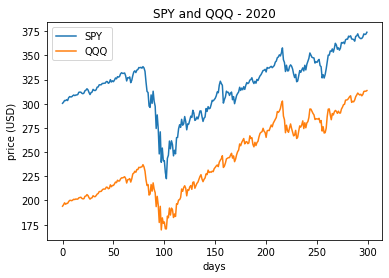

In [2]:
import matplotlib.pyplot as plt

plt.plot(spy, label=spy.name)
plt.plot(qqq, label=qqq.name)
plt.xlabel("days")
plt.ylabel("price (USD)")
plt.title("SPY and QQQ - 2020")
plt.legend()
plt.show()

We can clearly see a very strong corellation between these two assets.  They share a lot of the same movement.

We'll use the techniques from last week to develop a pairs trading strategy.

Luckily for us there's a single function we can use to test if these two time series's are cointegrated.

In [6]:
from statsmodels.tsa.stattools import coint # test cointegration - H0: no cointegration

def is_cointegrated(series1, series2, significance=.01):
    # assumes series 1 and 2 are I(1)
    _, p_value, _ = coint(series1, series2)
    if p_value < significance:
        return True
    return False

is_cointegrated(spy, qqq)

False

Interesting, so even though it looks like there should be cointegration, the test does not confirm our hypothesis.
Maybe we should check a different timeframe, since oftentimes assets might be not cointegrated on one time scale, yet cointegrated on a different scale.  

This illustrates an important point.  We can have correlation without cointegration (converse is also true).
- We really need a statistical backing to be sure that cointegration exists, or else we could likely make a very expensive mistake. 

In [7]:
spy = make_dataframe(get_historical_data("minute", "SPY", 1000, '2020-01-01', '2020-12-31'), "SPY")["o"]
qqq = make_dataframe(get_historical_data("minute", "QQQ", 1000, '2020-01-01', '2020-12-31'), "QQQ")["o"]
# we'll just take the closing price for each day
spy.name = "SPY"
qqq.name = "QQQ"
print(spy)
print(qqq)

0      370.90
1      370.99
2      371.12
3      371.37
4      371.32
        ...  
995    374.10
996    374.28
997    374.23
998    374.30
999    374.41
Name: SPY, Length: 1000, dtype: float64
0      312.94
1      313.02
2      312.93
3      312.98
4      313.06
        ...  
995    313.82
996    313.83
997    313.81
998    313.96
999    313.97
Name: QQQ, Length: 1000, dtype: float64


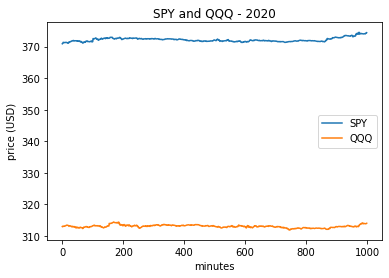

In [8]:
plt.plot(spy, label=spy.name)
plt.plot(qqq, label=qqq.name)
plt.xlabel("minutes")
plt.ylabel("price (USD)")
plt.title("SPY and QQQ - 2020")
plt.legend()
plt.show()

In [9]:
is_cointegrated(spy, qqq)

False

This also doesn't pass our test.  This illustrates an improtant idea, we can't just trust pictures.

### A different approach
Instead we may want to just feed a list of stocks to some function, then that function finds the cointegrated pairs and returns them.  
- Bias and overfitting is very likely in such a scenario, since we could perhaps have some third variable that is actually causing the cointegration between two assets.  
- This approach is useful to find pairs, but we would also want to examine the pairs from an economic perspective instead of blindly trusting our model.  
    - Always backing models with (basic) economic justification is a very important part of quantitative finance.  A lot of times we can just take a trading strategy as a black box without every wondering why it works, but this is incredibly useful to understand its limitations and shortcomings.  

In [10]:
def find_coint_pairs(stocks: list):
    pairs = []
    for asset1 in stocks:
        for asset2 in stocks:
            price1 = make_dataframe(get_historical_data("day", asset1, 300, '2020-01-01', '2020-12-31'), asset1)["c"]
            price2 = make_dataframe(get_historical_data("day", asset2, 300, '2020-01-01', '2020-12-31'), asset2)["c"]
            if asset1 is not asset2 and is_cointegrated(price1, price2):
                    pairs.append([asset1, asset2])
    return pairs

In [11]:
find_coint_pairs(["AAPL", "JPM", "TWTR", "F", "TSLA", "PG", "V", "WMT", "KO", "HD", "NKE", "SPY", "QQQ"])
# just a random-ish list of stocks from a handful of sectors

[['TWTR', 'NKE'], ['NKE', 'TWTR']]

### Understanding the output
Our function tells us that Nike and Twitter are cointegrated stocks, but there are a couple important assumptions we made.
- Our timeframe is on a day scale.  If we wanted to have a minute timescale, we would have to retest our model.  
- We test it on a 300 day lookback.  It's not necessarily true that we could look further back in time and maintain cointegration.

In [13]:
nke = make_dataframe(get_historical_data("day", "NKE", 300, '2020-01-01', '2020-12-31'), "NKE")["c"]
twtr = make_dataframe(get_historical_data("day", "TWTR", 300, '2020-01-01', '2020-12-31'), "TWTR")["c"]
nke.name = "NKE"
twtr.name = "TWTR"

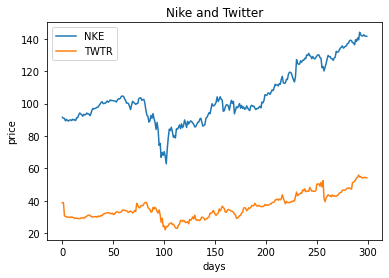

In [14]:
plt.plot(nke, label=nke.name)
plt.plot(twtr, label=twtr.name)
plt.xlabel("days")
plt.ylabel("price")
plt.title("Nike and Twitter")
plt.legend()
plt.show()

These look pretty good, and now we have proper statistical reasoning behind why our pair should work.
- In reality we could do something crazy like feeding the entire S&P 500 into this function, but what we would likely end up with is a lot of pairs that are controlled by some confounding variable that is actually what is moving the pair.  
- Whenever we're doing statarb, we want our bet to be about the stock's were trading only and not some third variable that we're unaware of.
    - Knowing the limitations of the model is arguably the most important task in data science, and that maintains true here.
    - This is why targeted approaches to finding cointegrated pairs is very important.  

### Generating the Alpha Coefficient

In [15]:
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools import add_constant

def estimate_coef(series1, series2, window=30):  # inputs are X, Y
    series1.name = "slope"
    series1 = add_constant(series1)
    combination = RollingOLS(series2, series1, window=window).fit()  # in form (dependent, independent)
    # Need rolling OLS to prevent look ahead bias - guarenttes we're only predicting beta using values we already know
    # const is not important since it just shifts mean to 0.  
    return combination.params["slope"]
    
alpha = estimate_coef(nke, twtr)
alpha

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
295    0.891890
296    0.957785
297    1.023928
298    1.086998
299    1.074001
Name: slope, Length: 300, dtype: float64

Rolling regression is important because we don't want our $\alpha$ to depend on values in the future, which we would not yet know.
- Instead, our $\alpha$ depends on the past 30 days.
- We may get different results in backtests based on what window length we choose, but we should be careful because this is likely going to lead to overfitting. 

### Making the spread
What we just predicted was a slope $\alpha$ for a linear model of the form $\text{Twitter} = \alpha * \text{Nike} + c$
- The constant really isn't important since it's just a shift factor.

In [16]:
import numpy as np
spread = np.array(twtr) - alpha * np.array(nke)
spread.name = "spread"
spread

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
295   -72.324016
296   -81.996960
297   -90.669448
298   -99.599787
299   -97.798952
Name: spread, Length: 300, dtype: float64

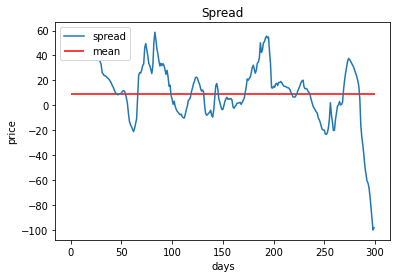

In [17]:
plt.plot(spread, label=spread.name)
plt.hlines(spread.mean(), 0,  len(spread), colors="red", label="mean")
plt.xlabel("days")
plt.ylabel("price")
plt.title("Spread")
plt.legend()
plt.show()

What we've done here is created a derivative, whose price is $T_i - \alpha S_i$ where $T_i$ = Twitter and $S_i$ = Nike.
- We can go **go long the spread** when the above is sufficiently small
- We'll can go **go short the spread** when the above is sufficiently large

- What we notice is that this price is **mean reverting**.  When it's large or small, it tends to go back to the mean.  We can use this belief to make bets on a mean reversion whenever we sufficiently diverge.

- If this price is large, then $T_i >> \alpha S_i$, so we would expect $T_i$ to decrease and $S_i$ to increase.
    - Thus, we can short $T_i$ and long $\alpha$ units of $S_i$.  This is a very secure investment since we're equally esposed to the market.
        - Notice around the 50-100 day mark (march 2020) when the stock market in general was tanking (as were our individual assets).  Our derivative diverges from the mean, but it does so in exactly the manner we would expect.
        - This strategy is generally pretty safe to extrememe market movement.  
- If this price is small, then $T_i << \alpha S_i$, so we would expect $T_i$ to increase and $S_i$ to decrease.
    - Thus, we can buy $T_i$ and short $\alpha$ units of $S_i$.  
- Once our price goes back towards the mean, we can dump our shares for a solid profit.  

- A very important thing to do, however, is always check whether our cointegration relationship still exists.  We can notice a very large divergence in the above plot around 300, so this might be an indication that our relationship is weakening.
    - If we wanted to trade this strategy, we would want tons of pairs that we're tracking since at any given point a pair might fail to be cointegrated, in which case we'd want to replace it with another pair.
    
### Important Nuance
- Notice that our idea of the **mean** in this case has nothing to do with the underlying assets.
    - As previously discussed, it would be incorrect to say that an individual stock has a well defined mean, since oftentimes the asset's price is not stationary.  
        - You would likely lose a lot of money if you build a mean reversion strategy on a single asset.
    - But in this case we constructed a stationary time series, which has a well defined mean, so it makes sense to bet on mean reversions when we have divergence from the mean.

In [18]:
# to take this further, let's normalize this spread using a z-score
mean_30 = spread.rolling(window=30).mean()
std_30 = spread.rolling(window=30).std()

norm_spread = (spread - mean_30) / std_30

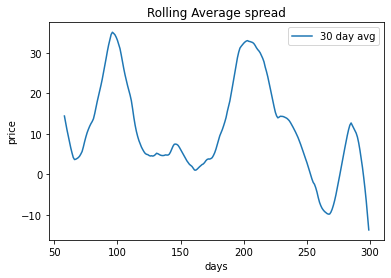

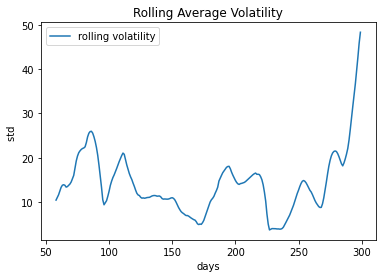

In [19]:
# let's see what this rolling mean and std look like
plt.plot(mean_30, label="30 day avg")
plt.xlabel("days")
plt.ylabel("price")
plt.title("Rolling Average spread")
plt.legend()
plt.show()

plt.plot(std_30, label="rolling volatility")
plt.xlabel("days")
plt.ylabel("std ")
plt.title("Rolling Average Volatility")
plt.legend()
plt.show()

Notice that the 30 day mean spread is much smoother than the original spread.

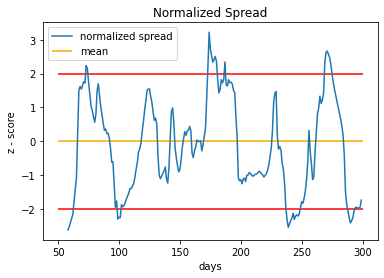

In [24]:
plt.plot(norm_spread, label="normalized spread")
plt.hlines(2, 50,  len(spread), colors="red")
plt.hlines(-2, 50,  len(spread), colors="red")
plt.hlines(0, 50,  len(spread), colors="orange", label="mean")
plt.xlabel("days")
plt.ylabel("z - score")
plt.title("Normalized Spread")
plt.legend()
plt.show()

This plot is much closer to what we would actually use to produce buy/sell signals.
- When z score is above 2 we would sell the spread.
- When z score is below -2 we would buy the spread.
    - We chose 2 and -2 since that's 2 standard deviations above and below the mean, so it should only happen a handful of times.
        - If we chose 1 we would likely miss out on a lot of profit since spread tends to continue increasing at 1, whereas if we chose 3 then we wouldn't be making a lot of purchases and similarly miss out of profit.
        - 2 works nice since it's pretty close to the maximum of the spread at each occurance, so we're nearing maximum profit.
- Notice that we can say nothing about when our spread will actually mean revert in terms of timeframe.
    - All we know is that at some point our spread should return to around 0, which is when we'll dump our shares for hopefully a solid profit.
    - Just from looking at the chart we can see that it's roughly around 25ish day from when we would purchase the assets to when we would expect to sell them.
        - Depending on the type of trading someone wants to do that might be out of their comfort zone and risk tolerance.  A lot can happen in 25 days of trading in terms of macro events (interst rates, Federal Reserve, ect).